# Model Report

In [1]:
import re
import warnings
from pathlib import Path
from time import time
from typing import Dict, List, Tuple

import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

from src.command_line_interfaces import cli_helpers
from src.modeling.pymc3_analysis import get_hdi_colnames_from_az_summary
from src.modeling.simulation_based_calibration_helpers import SBCFileManager

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("..", "models", "modeling_cache", "pymc3_model_cache")

Parameters for papermill:

- `MODEL_NAME`: unique, identifiable name of the model
- `SBC_RESULTS_DIR`: directory containing results of many rounds of SBC
- `SBC_COLLATED_RESULTS`: path to collated simulation posteriors
- `NUM_SIMULATIONS`: the number of simiulations; will be used to check that all results are found
- `CONFIG_PATH`: path to the model configuration file

## Setup

### Papermill parameters

In [2]:
MODEL_NAME = ""
SBC_RESULTS_DIR = ""
SBC_COLLATED_RESULTS = ""
NUM_SIMULATIONS = -1
CONFIG_PATH = ""

In [3]:
# Parameters
MODEL_NAME = "sp4-default-fullrank"
SBC_RESULTS_DIR = "/n/scratch3/users/j/jc604/speclet-sbc/sp4-default-fullrank_ADVI"
SBC_COLLATED_RESULTS = (
    "cache/sbc-cache/sp4-default-fullrank_ADVI_collated-posterior-summaries.pkl"
)
NUM_SIMULATIONS = 2
CONFIG_PATH = "models/model-configs.yaml"

### Prepare and validate papermill parameters

Check values passed as the directory with results of the rounds of SBC.

In [4]:
path_addition = "../.."

sbc_results_dir = Path(path_addition, SBC_RESULTS_DIR)
assert sbc_results_dir.is_dir()
assert sbc_results_dir.exists()

sbc_collated_results_path = Path(path_addition, SBC_COLLATED_RESULTS)
assert sbc_collated_results_path.is_file()
assert sbc_collated_results_path.exists()

Confirm that there is a positive number of simulations.

In [5]:
assert NUM_SIMULATIONS > 0

## Read in all results

In [6]:
simulation_posteriors_df = pd.read_pickle(sbc_collated_results_path)
simulation_posteriors_df.head()

,,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,true_value,simulation_id,within_hdi
parameter,parameter_name,,,,,,,,,,,,
μ_h,μ_h,0.761,0.207,0.429,1.086,0.007,0.005,850.0,863.0,NaN,0.400157,sim_id_0000,False
μ_d,μ_d,0.377,0.086,0.238,0.512,0.003,0.002,969.0,937.0,NaN,1.532779,sim_id_0000,False
μ_η,μ_η,0.188,0.198,-0.126,0.502,0.007,0.005,803.0,932.0,NaN,0.352810,sim_id_0000,True
h[0],h,1.922,0.161,1.676,2.191,0.005,0.004,1021.0,843.0,NaN,2.593405,sim_id_0000,False
h[1],h,1.520,0.141,1.313,1.760,0.005,0.003,980.0,766.0,NaN,2.228007,sim_id_0000,False


## Analysis

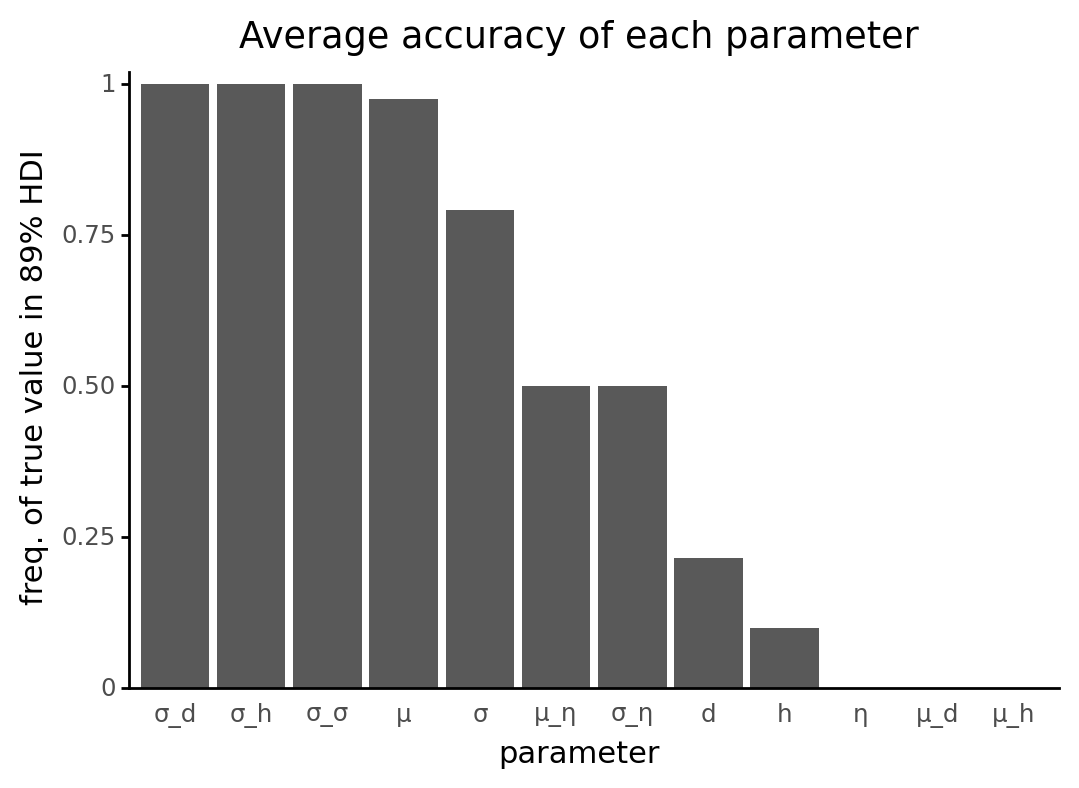

<ggplot: (2977518140781)>

In [7]:
accuracy_per_parameter = (
    simulation_posteriors_df.copy()
    .groupby(["parameter_name"])["within_hdi"]
    .mean()
    .reset_index(drop=False)
    .sort_values("within_hdi", ascending=False)
    .reset_index(drop=True)
)

accuracy_per_parameter["parameter_name"] = pd.Categorical(
    accuracy_per_parameter["parameter_name"],
    categories=accuracy_per_parameter["parameter_name"].values,
)

(
    gg.ggplot(accuracy_per_parameter, gg.aes(x="parameter_name", y="within_hdi"))
    + gg.geom_col()
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(
        x="parameter",
        y="freq. of true value in 89% HDI",
        title="Average accuracy of each parameter",
    )
    + gg.theme(axis_ticks_major_x=gg.element_blank(), figure_size=(6, 4))
)

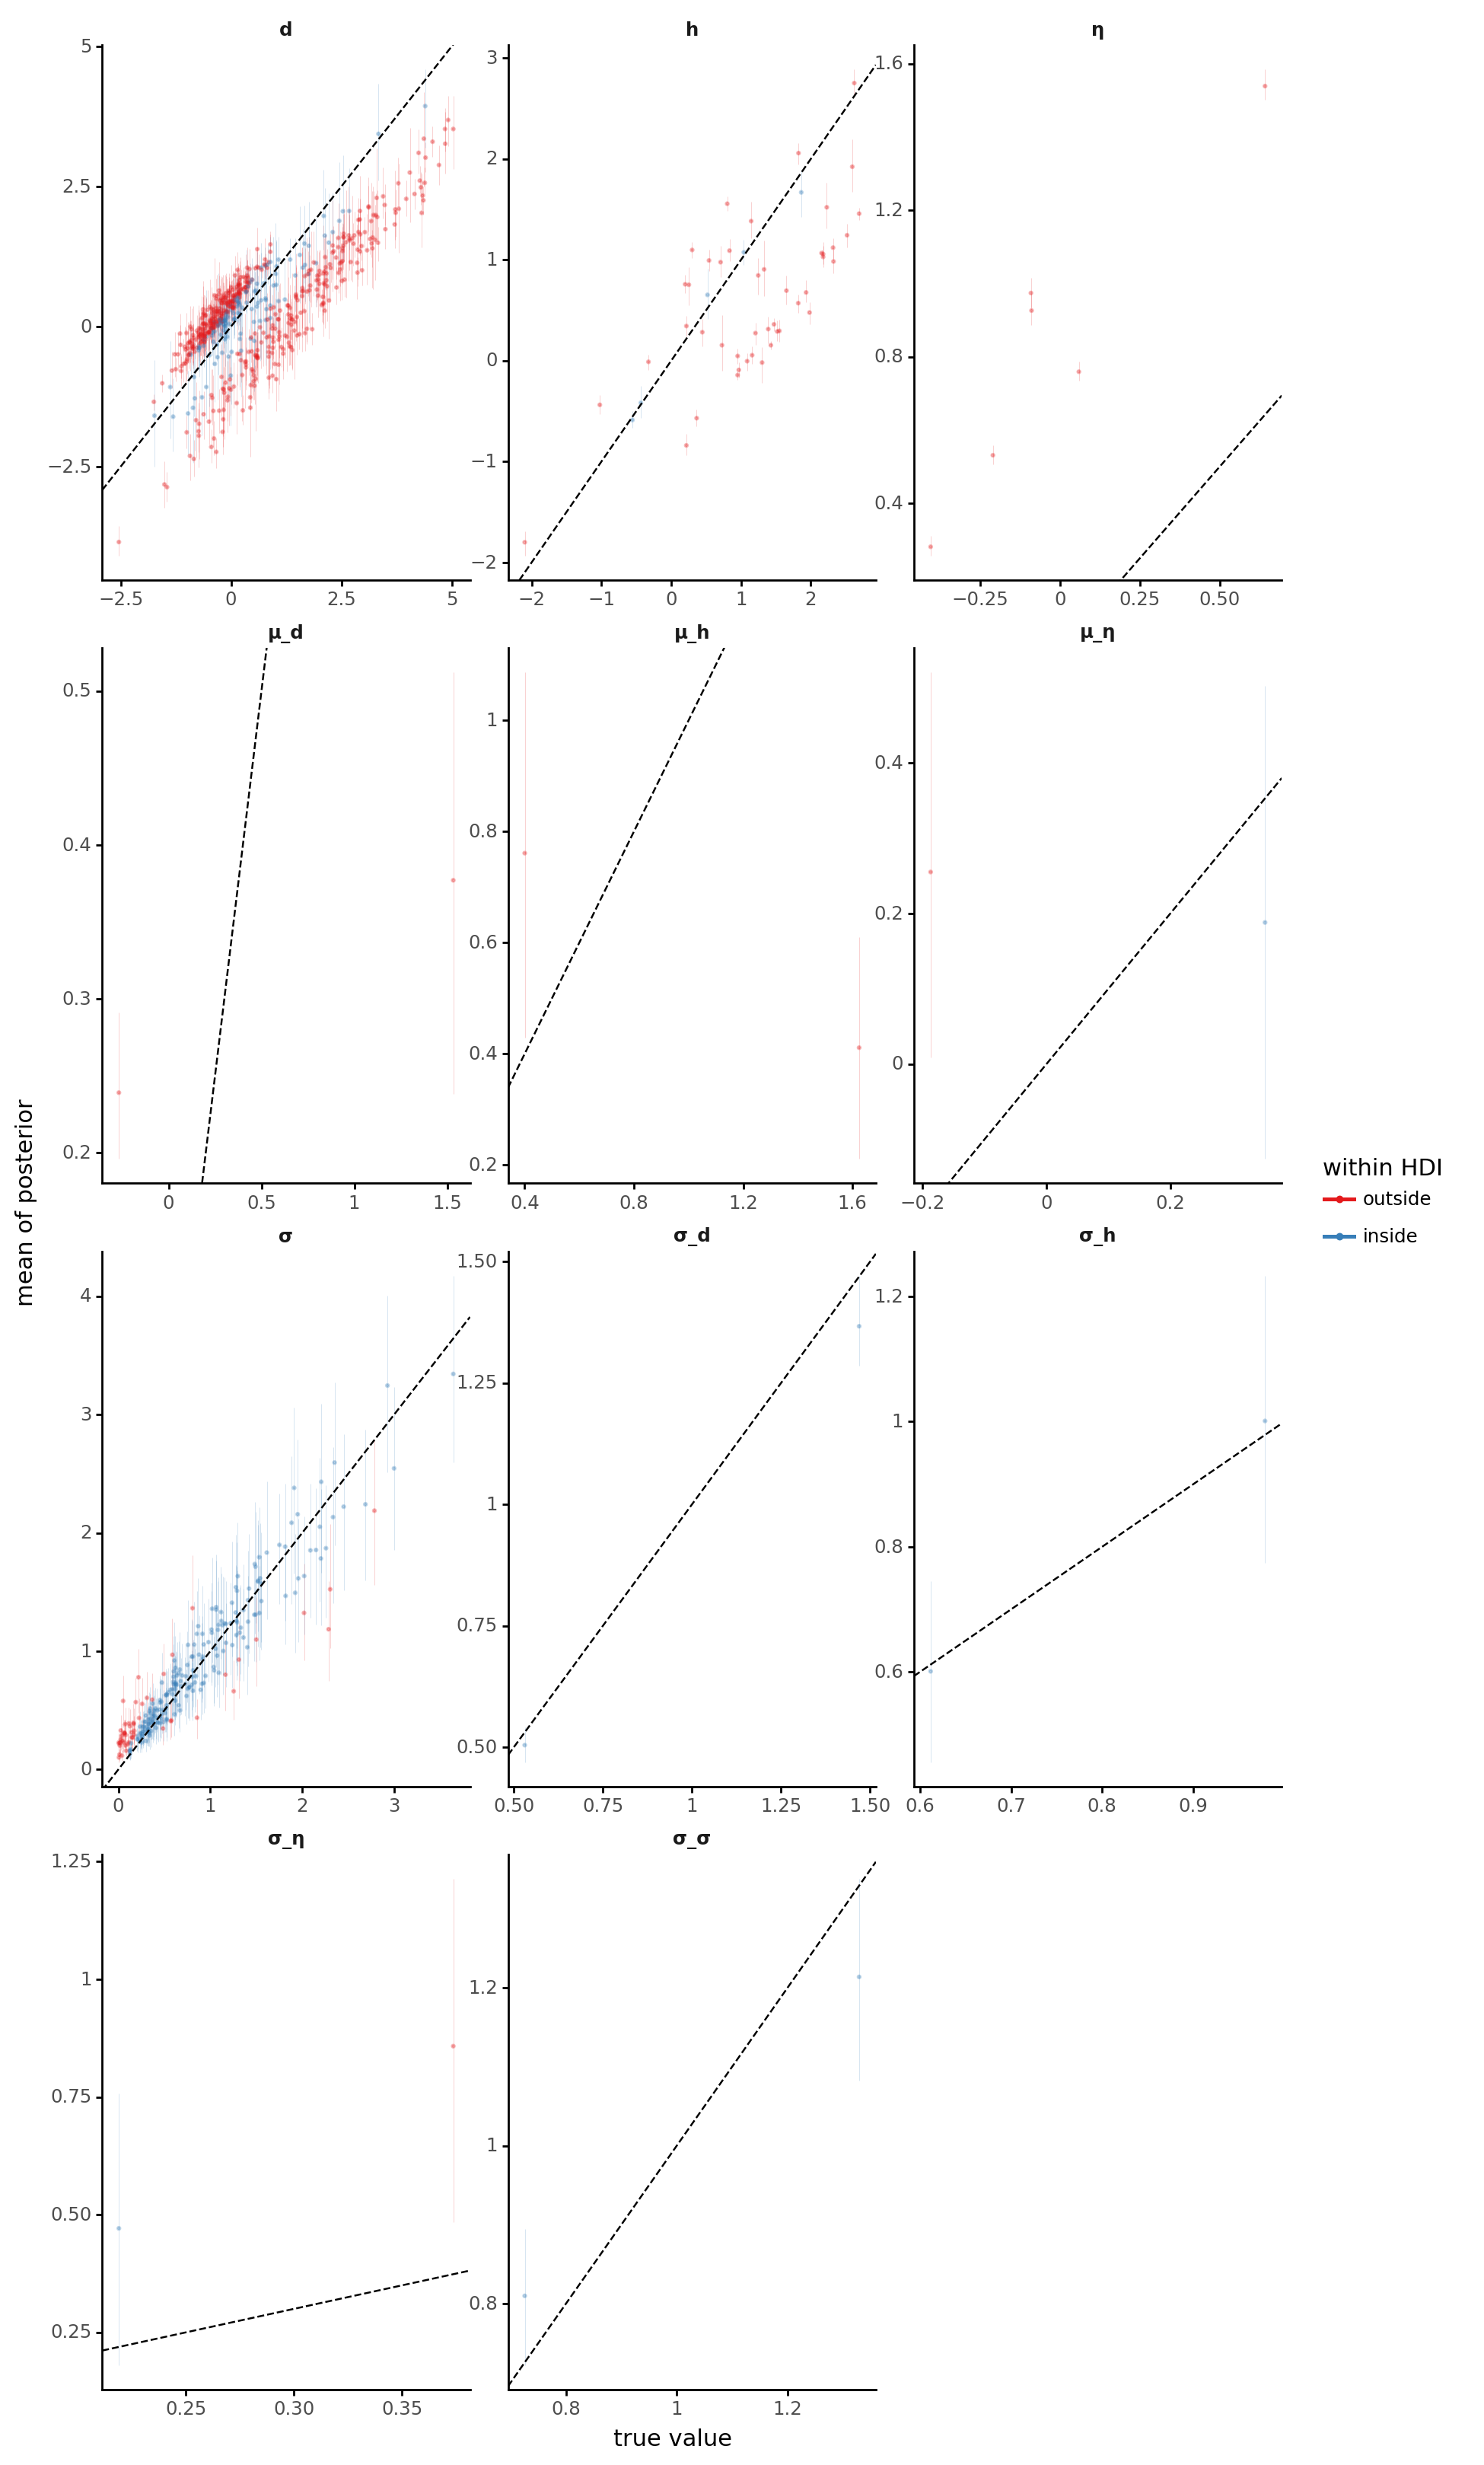

<ggplot: (2977526657521)>

In [8]:
hdi_low, hdi_high = get_hdi_colnames_from_az_summary(simulation_posteriors_df)


def filter_uninsteresting_parameters(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.reset_index(drop=False)
        .query("parameter_name != 'μ'")
        .filter_string("parameter_name", search_string="offset", complement=True)
    )


(
    gg.ggplot(
        filter_uninsteresting_parameters(simulation_posteriors_df),
        gg.aes(x="true_value", y="mean", color="within_hdi"),
    )
    + gg.facet_wrap("~ parameter_name", ncol=3, scales="free")
    + gg.geom_linerange(gg.aes(ymin=hdi_low, ymax=hdi_high), alpha=0.2, size=0.2)
    + gg.geom_point(size=0.3, alpha=0.3)
    + gg.geom_abline(slope=1, intercept=0, linetype="--")
    + gg.scale_color_brewer(
        type="qual",
        palette="Set1",
        labels=("outside", "inside"),
        guide=gg.guide_legend(
            title="within HDI",
            override_aes={"alpha": 1, "size": 1},
        ),
    )
    + gg.theme(
        figure_size=(10, 20),
        strip_background=gg.element_blank(),
        strip_text=gg.element_text(face="bold"),
        panel_spacing=0.25,
    )
    + gg.labs(
        x="true value",
        y="mean of posterior",
    )
)

---

In [9]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.08 minutes


In [10]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-08

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-242.o2.rc.hms.harvard.edu

Git branch: pipeline-confg

arviz     : 0.11.2
matplotlib: 3.3.4
plotnine  : 0.7.1
pandas    : 1.2.3
re        : 2.2.1
pymc3     : 3.11.1
numpy     : 1.20.1
seaborn   : 0.11.1
janitor   : 0.20.14

